In [1065]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split,nearest_points
from newton_multidimention import Optimize_Drone_Position_Euclidean

background = mpimg.imread('./map.png')
plt.style.use('default')

## Creating the delivery Locations

In [1066]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        # loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        # loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc_x = random.uniform(x[0],y[0])
        loc_y = random.uniform(x[1],y[1])
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [1067]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [1068]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [1069]:
def initial_plot(delivery_loc, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("Delivery Locations")
    # plt.grid(True)
    # plt.xticks(np.arange(22.21,34.45,0.1), rotation='vertical')
    # plt.yticks(np.arange(88.45,98.67,0.1))

    # mpldatacursor.datacursor()
    plt.show()

In [1070]:
def clusters_plot(clusters, centroids, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]
        
        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("After Clustering")
    plt.show()

In [1071]:
def dp_plot(clusters, centroids, dp, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("After DP Creation")
    plt.show()

In [1072]:
def final_plot(delivery_loc,clusters, dp, obstacles, title=None):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])
        # plt.scatter(pts[:,0], pts[:,1])
        #try
        # points = pts[1:-1,:]
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    if title != None:
        plt.title(title)
    else:
        plt.title("Final Result")
    # plt.show()

## KMeans Clustering

In [1073]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [1074]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [1075]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [1076]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

In [1077]:
from shapely.ops import split

In [1078]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [1079]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line_intersect(line,obs):
            return False
    return True

In [1080]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.001
    increment = 0.001
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

<font color="red">Try</font>

In [1081]:
from shapely.affinity import translate

In [1082]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [1083]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [1084]:
def varify_dp(dp, obstacles):
    new_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            new_dp = relocate_dp(cur_dp, obstacle_polygon)
            break
    
    return dp if new_dp == None else new_dp

In [1085]:
import networkx as nx

def create_shortest_path(point_1, point_2, obstacles):
    route_line = LineString([point_1, point_2])

    intersections = []
    # for obstacle in obstacles:
    #     for i in range(len(obstacle.exterior.coords) - 1):
    #         start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
    #         line = LineString([start, end])
    #         if route_line.intersects(line):
    #             intersections.append(start)
    #             intersections.append(end)

    for obstacle in obstacles:
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # create new polygon
    # for id,obstacle in enumerate(obstacles):
    #     obstacles[id] = scale_polygon(obstacle)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if is_obstacle_free(line, obstacles):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=True)
    # nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return path

In [1086]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      # intermediate_point = find_inter_point(point_a, point_b, obstacles)
      intermediate_point = create_shortest_path(point_a, point_b, obstacles.copy())
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [1087]:
def create_distance_matrix(points,obstacles,dp=None):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    if dp != None:
        points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
            if inter != None:
                inter_matrix[(src_point, dest_point)] = inter
    
    return matrix, inter_matrix

In [1088]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end

In [1089]:
def tsp_crysto(cluster, dp, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    
    path = cluster
    path.append(dp)
    path.insert(0, dp)

    G = nx.Graph()

    for pt in path:
        G.add_node(tuple(pt))

    for i in range(len(path)-1):
        for j in range(i+1,len(path)):
            G.add_edge(tuple(path[i]),tuple(path[j]), weight = distance_matrix[(tuple(path[i]), tuple(path[j]))])

    path = nx.approximation.traveling_salesman.christofides(G, weight='weight')

    #insert intermediate points
    ans_route = []
    for loc in range(len(path)-1):
        ans_route.append(path[loc])
        if inter_point_matrix.get((tuple(path[loc]), tuple(path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    return ans_route

In [1090]:
def minimum_span_tree(cluster, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles)
    paths = list(permutations(cluster))
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(min_path[-1])

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    

In [1091]:
def merge_dp(cluster, entry_exit_dp, obstacles):
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    path_1 = create_shortest_path(entry_exit_dp, cluster[0], obstacle_polygon)
    path_2 = create_shortest_path(cluster[-1],entry_exit_dp, obstacle_polygon)
    
    new_cluster = path_1 + cluster + path_2

    return new_cluster

## Main

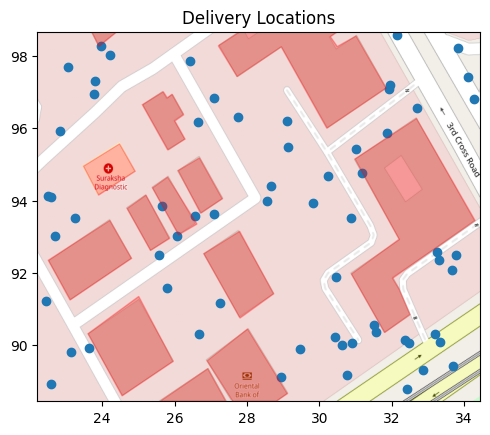

In [1092]:
n = random.randint(30,81)
k = 8

# creating the boundary
x = [22.21, 88.45]
y = [34.45, 98.67]
delivery_loc = create_locations(x, y, n)

# obstacles
obstacles = {
    0 : [[27.81, 90.75],[28.74, 91.42],[27.80, 93.15], [26.81, 92.53], [27.81, 90.75]],
    1 : [[23.11, 91.25], [24.81, 92.40], [24.21, 93.45], [22.51, 92.35],[23.11, 91.25]],
    2 : [[24.55, 88.60],[25.96, 89.55],[25.01, 91.35],[23.61, 90.32],[24.55, 88.60]],
    3 : [[25.60, 88.45], [27.42, 88.45],[26.92, 89.35],[25.60, 88.45]],
    4 : [[27.61, 88.45], [28.81, 88.45],[29.12, 88.66],[28.02, 90.45],[26.90, 89.57],[27.61, 88.45]],
    5 : [[25.33, 92.62], [25.86, 92.95], [25.21, 94.15], [24.69, 93.78], [25.33, 92.63]],
    6 : [[26.11, 93.05], [26.62, 93.35], [25.81, 94.65], [25.39, 94.35], [26.11, 93.05]],
    7 : [[26.72, 93.65], [27.32, 94.05], [26.69, 95.18], [26.10, 94.83], [26.72, 93.65]],
    8 : [[25.81, 95.40],[26.29, 95.70],[26.01, 96.20],[26.25, 96.37],[25.93, 96.94],[25.80, 96.84], [25.69, 97.01],[25.11, 96.65],[25.81, 95.40]],
    9 : [[23.90, 94.15], [24.91, 94.81], [24.48, 95.57],[23.48, 94.95],[23.90, 94.15]],
    10 : [[23.71, 98.67], [23.91, 98.26], [24.41, 98.67],[23.71, 98.67]],
    11 : [[31.81, 90.35], [32.51, 90.85], [32.21, 91.55], [32.03, 91.85], [34.31, 93.45], [32.69, 96.27],[30.99, 95.15], [32.21, 92.93],[30.89, 91.97],[31.81, 90.35]],
    12 : [[30.21, 96.00],[31.85, 97.11], [31.02, 98.55], [30.50, 98.26], [30.31, 98.53], [30.51, 98.67],[27.81, 98.67], [27.21, 98.28], [27.73, 97.43],[28.95, 98.25],[30.21, 96.00]]
}

delivery_loc = verify_locations(delivery_loc, obstacles)

n = len(delivery_loc)

# Visualize the data
initial_plot(delivery_loc, obstacles)

{0: [[32.69536421880694, 96.5679619990376], [32.14783405438663, 98.58157411318584], [31.941880957758972, 97.07788893141587], [34.28823065218647, 96.79941260121868], [34.10945999839042, 97.42611808935388], [31.946048065685503, 97.18239751185341], [31.87757358235583, 95.85730986238401], [33.84796226284813, 98.2259182689189]], 1: [[23.630917561442402, 89.92450237082778], [22.57328372707936, 88.92634209424924], [22.434556361210205, 91.23200544231433], [22.700102004837962, 93.0140070932824], [22.509296562778214, 94.11944620530899], [23.138470579314, 89.82468817985172], [23.240067201203598, 93.5216981440602], [22.584550319569658, 94.09475826044567]], 2: [[33.661988281778314, 92.09363106108833], [33.33105876891446, 90.10089267328159], [32.864304132437965, 89.31458856400015], [33.19312310479894, 90.3120012567307], [32.421811040488755, 88.79952019293569], [33.69366531142129, 89.41181708165425], [32.47572406199179, 90.05854563067663], [32.36331601907991, 90.14619494559695]], 3: [[28.546996338644

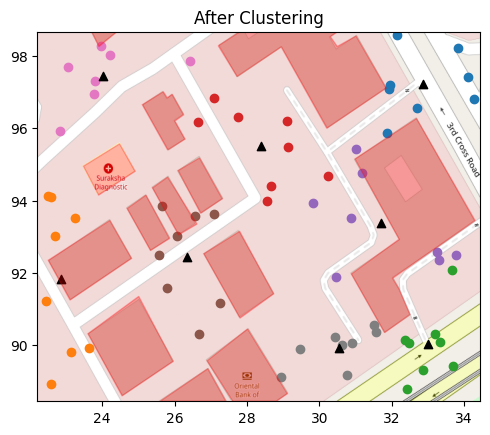

In [1093]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

In [1094]:
cluster_1 = clusters.copy()
cluster_2 = clusters.copy()
cluster_3 = clusters.copy()
cluster_4 = clusters.copy()
last_cluster = clusters.copy()

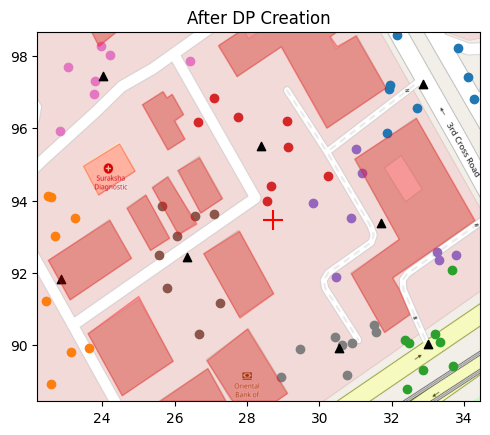

In [1095]:
# Calculate DP
DP = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, DP, obstacles)

In [1096]:
# change dp location if dp on obstacle
DP = varify_dp(DP, obstacles)

In [1097]:
def initial_tsp(cluster, dp, method="christofides"):
    
    if method == "christofides":
        path = cluster
        path.append(dp)
        path.insert(0, dp)

        G = nx.Graph()

        for pt in path:
            G.add_node(tuple(pt))

        for i in range(len(path)-1):
            for j in range(i+1,len(path)):
                G.add_edge(tuple(path[i]),tuple(path[j]), weight = calculate_distance(path[i], path[j]))

        path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    
    elif method == 'brut_force':
        path = list(permutations(cluster))
        cost = []
        # add dp at the start and end
        for i in range(len(path)):
            path[i] = list(path[i])
            path[i].append(dp)
            path[i].insert(0, dp)

            # Calculate distance
            points = path[i]
            sum = 0

            for j in range(len(points)-1):
                sum += calculate_distance(points[j], points[j+1])
            cost.append(sum)

        idx = np.argmin(cost)
        path = path[idx]

        print("Path ",path)

    return path

Path  [[28.7124444103638, 93.4693044626262], [31.941880957758972, 97.07788893141587], [31.946048065685503, 97.18239751185341], [32.14783405438663, 98.58157411318584], [33.84796226284813, 98.2259182689189], [34.10945999839042, 97.42611808935388], [34.28823065218647, 96.79941260121868], [32.69536421880694, 96.5679619990376], [31.87757358235583, 95.85730986238401], [28.7124444103638, 93.4693044626262]]
Path  [[28.7124444103638, 93.4693044626262], [23.240067201203598, 93.5216981440602], [22.584550319569658, 94.09475826044567], [22.509296562778214, 94.11944620530899], [22.700102004837962, 93.0140070932824], [22.434556361210205, 91.23200544231433], [22.57328372707936, 88.92634209424924], [23.138470579314, 89.82468817985172], [23.630917561442402, 89.92450237082778], [28.7124444103638, 93.4693044626262]]
Path  [[28.7124444103638, 93.4693044626262], [33.661988281778314, 92.09363106108833], [33.19312310479894, 90.3120012567307], [33.33105876891446, 90.10089267328159], [33.69366531142129, 89.4118

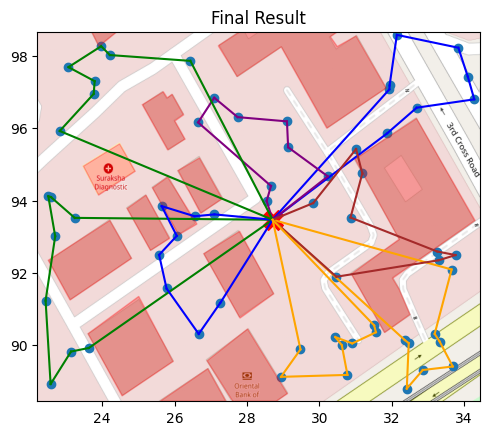

In [1098]:
for i in cluster_1:
    cluster_1[i] = initial_tsp(cluster_1[i], DP, method="brut_force")

final_plot(delivery_loc,cluster_1, DP, obstacles)

In [1099]:
initial_distance = total_distance(cluster_1)
print("Initial distance, without considering obstacles :",initial_distance)

Initial distance, without considering obstacles : 117.69783887791992


#### Cluster -> Brute Force

In [1100]:
# Shortest path calculation in each cluster
for i in cluster_2:
    cluster_2[i] = tsp_brut(cluster_2[i].copy(), DP, obstacles)


Optimal path [[28.7124444103638, 93.4693044626262], [31.941880957758972, 97.07788893141587], [31.946048065685503, 97.18239751185341], [32.14783405438663, 98.58157411318584], [33.84796226284813, 98.2259182689189], [34.10945999839042, 97.42611808935388], [34.28823065218647, 96.79941260121868], [32.69536421880694, 96.5679619990376], [31.87757358235583, 95.85730986238401], [28.7124444103638, 93.4693044626262]] optimal distance 16.248921447084008
Optimal path [[28.7124444103638, 93.4693044626262], [23.240067201203598, 93.5216981440602], [22.584550319569658, 94.09475826044567], [22.509296562778214, 94.11944620530899], [22.700102004837962, 93.0140070932824], [22.434556361210205, 91.23200544231433], [22.57328372707936, 88.92634209424924], [23.138470579314, 89.82468817985172], [23.630917561442402, 89.92450237082778], [28.7124444103638, 93.4693044626262]] optimal distance 20.462824848463477
Optimal path [[28.7124444103638, 93.4693044626262], [33.661988281778314, 92.09363106108833], [33.193123104

In [1101]:
for i in cluster_2:
    print("Path",i,":")
    for j in cluster_2[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
[28.7124444103638, 93.4693044626262] -> [31.941880957758972, 97.07788893141587] -> [31.946048065685503, 97.18239751185341] -> [32.14783405438663, 98.58157411318584] -> [33.84796226284813, 98.2259182689189] -> [34.10945999839042, 97.42611808935388] -> [34.28823065218647, 96.79941260121868] -> [32.69536421880694, 96.5679619990376] -> [31.87757358235583, 95.85730986238401] -> [28.7124444103638, 93.4693044626262] -> End
Path 1 :
[28.7124444103638, 93.4693044626262] -> (25.33, 92.62) -> (24.69, 93.78) -> [23.240067201203598, 93.5216981440602] -> [22.584550319569658, 94.09475826044567] -> [22.509296562778214, 94.11944620530899] -> [22.700102004837962, 93.0140070932824] -> (22.51, 92.35) -> [22.434556361210205, 91.23200544231433] -> [22.57328372707936, 88.92634209424924] -> [23.138470579314, 89.82468817985172] -> [23.630917561442402, 89.92450237082778] -> (23.61, 90.32) -> (25.01, 91.35) -> (26.81, 92.53) -> (27.8, 93.15) -> [28.7124444103638, 93.4693044626262] -> End
Path 2 :
[28.71

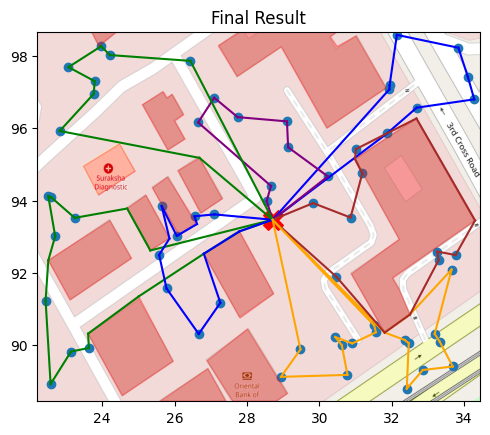

In [1102]:
# Final Visualization
final_plot(delivery_loc,cluster_2, DP, obstacles)

#### Cluster_2 -> Crystofieds

In [1103]:
# Shortest path calculation in each cluster
for i in cluster_3:
    cluster_3[i] = tsp_crysto(cluster_3[i].copy(), DP, obstacles)

In [1104]:
for i in cluster_3:
    print("Path",i,":")
    for j in cluster_3[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
(28.7124444103638, 93.4693044626262) -> (32.69536421880694, 96.5679619990376) -> (34.28823065218647, 96.79941260121868) -> (34.10945999839042, 97.42611808935388) -> (33.84796226284813, 98.2259182689189) -> (32.14783405438663, 98.58157411318584) -> (31.946048065685503, 97.18239751185341) -> (31.941880957758972, 97.07788893141587) -> (31.87757358235583, 95.85730986238401) -> [28.7124444103638, 93.4693044626262] -> End
Path 1 :
(28.7124444103638, 93.4693044626262) -> (25.33, 92.62) -> (24.69, 93.78) -> (22.509296562778214, 94.11944620530899) -> (22.584550319569658, 94.09475826044567) -> (23.240067201203598, 93.5216981440602) -> (22.700102004837962, 93.0140070932824) -> (22.51, 92.35) -> (22.434556361210205, 91.23200544231433) -> (23.138470579314, 89.82468817985172) -> (22.57328372707936, 88.92634209424924) -> (23.630917561442402, 89.92450237082778) -> (23.61, 90.32) -> (25.01, 91.35) -> (26.81, 92.53) -> (27.8, 93.15) -> [28.7124444103638, 93.4693044626262] -> End
Path 2 :
(28.71

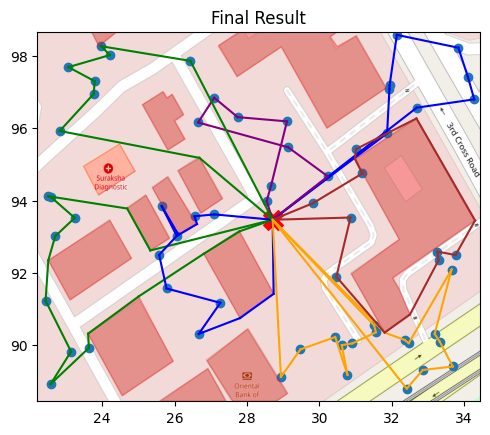

In [1105]:
final_plot(delivery_loc,cluster_3, DP, obstacles)

#### Cluster 3 -> Entry Exit method

In [1106]:
entry_exit_nodes = []

In [1107]:
# centroids, cluster_4 = KMeans(delivery_loc, n, k)

In [1108]:
for i, cluster in cluster_4.items():
    cluster_4[i] = minimum_span_tree(cluster.copy(), obstacles)

Optimal path [[34.28823065218647, 96.79941260121868], [34.10945999839042, 97.42611808935388], [33.84796226284813, 98.2259182689189], [32.14783405438663, 98.58157411318584], [31.946048065685503, 97.18239751185341], [31.941880957758972, 97.07788893141587], [32.69536421880694, 96.5679619990376], [31.87757358235583, 95.85730986238401]] optimal distance 6.7415812827053925
Optimal path [[22.57328372707936, 88.92634209424924], [23.138470579314, 89.82468817985172], [23.630917561442402, 89.92450237082778], [22.434556361210205, 91.23200544231433], [22.700102004837962, 93.0140070932824], [23.240067201203598, 93.5216981440602], [22.584550319569658, 94.09475826044567], [22.509296562778214, 94.11944620530899]] optimal distance 6.838319428054046
Optimal path [[33.661988281778314, 92.09363106108833], [32.36331601907991, 90.14619494559695], [32.47572406199179, 90.05854563067663], [33.19312310479894, 90.3120012567307], [33.33105876891446, 90.10089267328159], [33.69366531142129, 89.41181708165425], [32.8

In [1109]:
for i, cluster in cluster_4.items():
    entry_exit_nodes.append(cluster[0])
    entry_exit_nodes.append(cluster[-1])

In [1110]:
entry_exit_nodes

[[34.28823065218647, 96.79941260121868],
 [31.87757358235583, 95.85730986238401],
 [22.57328372707936, 88.92634209424924],
 [22.509296562778214, 94.11944620530899],
 [33.661988281778314, 92.09363106108833],
 [32.421811040488755, 88.79952019293569],
 [28.546996338644938, 93.98714578386199],
 [26.651314969114594, 96.15998333530297],
 [31.019806214509295, 95.42466885060115],
 [33.769784767955564, 92.49298125682587],
 [27.10201142715264, 93.61736726775656],
 [26.66845688440104, 90.3121279324274],
 [22.82562789654899, 95.9243487403329],
 [26.437362604572158, 97.86270930481253],
 [31.520548297592455, 90.546834876487],
 [28.942507177859504, 89.12519981114119]]

In [1111]:
entry_nodes = [entry_exit_nodes[i] for i in range(0,len(entry_exit_nodes),2)]
exit_nodes = [entry_exit_nodes[i] for i in range(1,len(entry_exit_nodes),2)]

In [1112]:
entry_exit_dp = calculate_dp(entry_exit_nodes)

print(entry_exit_dp)

[28.801037526563633, 93.25306432354591]


In [1113]:
entry_exit_dp = Optimize_Drone_Position_Euclidean(entry_nodes, exit_nodes, entry_exit_dp)[0]

print(entry_exit_dp)

New Drone: [28.67987737 93.70591559]
[28.67987737 93.70591559]


In [1114]:
entry_exit_dp = varify_dp(entry_exit_dp, obstacles)

In [1115]:
for cls_id, cluster in cluster_4.items():
    cluster_4[cls_id] = merge_dp(cluster, entry_exit_dp, obstacles)

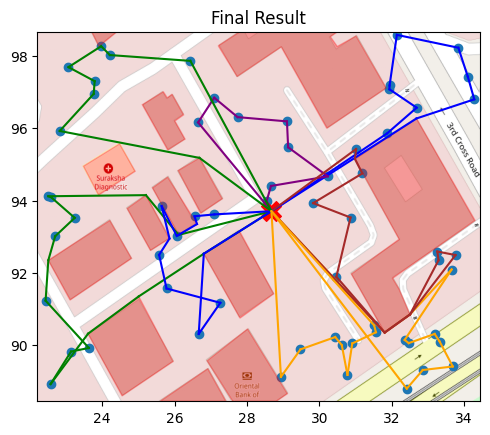

In [1116]:
# Final Visualization
final_plot(delivery_loc,cluster_4, entry_exit_dp, obstacles)

In [1117]:
entry_exit_distance = total_distance(cluster_4)
print("Distance considering obstacles and entry exit method :",entry_exit_distance)

Distance considering obstacles and entry exit method : 133.50996014322683


## Calculate Total DIstance

*Total distance in manhattan cluster*

In [1118]:
new_distance = total_distance(cluster_2)
print("Distance considering obstacles and brute force method :",new_distance)

Distance considering obstacles and brute force method : 126.68741598450335


In [1119]:
christofides_distance = total_distance(cluster_3)
print("Distance considering obstacles and christofides method :",christofides_distance)

Distance considering obstacles and christofides method : 131.26392720665598


In [1120]:
print(initial_distance)
print(new_distance)
print(christofides_distance)
print(entry_exit_distance)

117.69783887791992
126.68741598450335
131.26392720665598
133.50996014322683


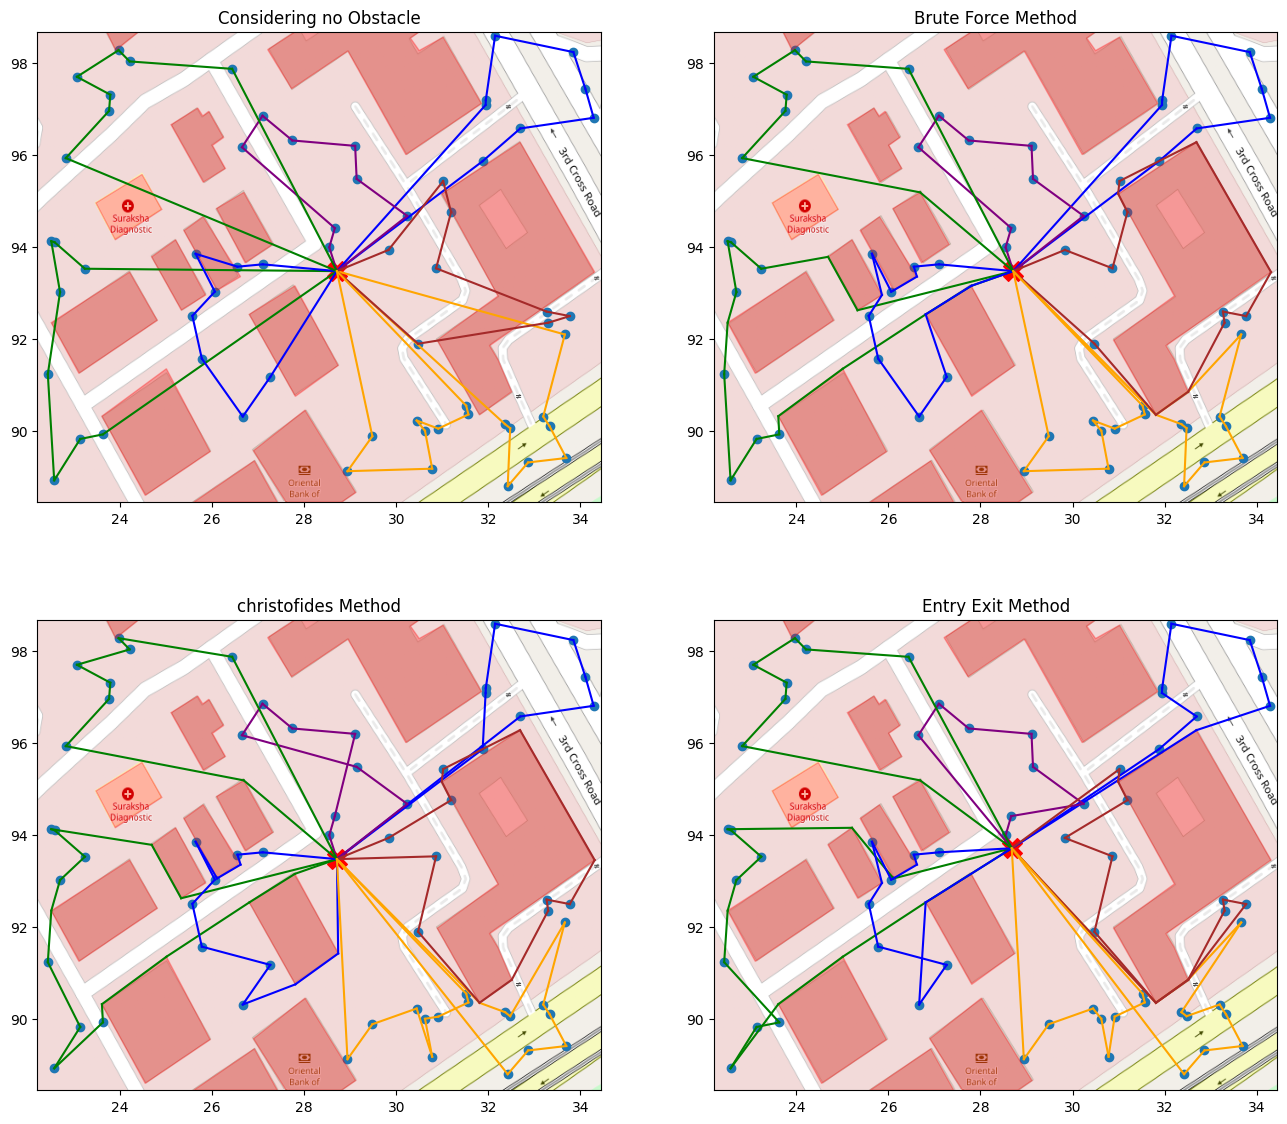

In [1121]:
plt.figure(figsize=(16,14))

plt.subplot(2,2,1)
final_plot(delivery_loc,cluster_1, DP, obstacles, title="Considering no Obstacle")
plt.subplot(2,2,2)
final_plot(delivery_loc,cluster_2, DP, obstacles, title = "Brute Force Method")
plt.subplot(2,2,3)
final_plot(delivery_loc,cluster_3, DP, obstacles, title = "christofides Method")
plt.subplot(2,2,4)
final_plot(delivery_loc,cluster_4, entry_exit_dp, obstacles, title = "Entry Exit Method")

plt.show()

## file handling

In [1122]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacle_capacity_k.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':k,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_distance,
    'brut_force_distance':new_distance,
    'christofides_distance':christofides_distance,
    'entry_exit_distance':entry_exit_distance
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,brut_force_distance,christofides_distance,entry_exit_distance
25,37,8,13,78.573429,82.828023,86.830296,92.362661
26,27,8,13,62.191940,65.557140,67.802540,70.228347
27,34,8,13,77.814320,83.552963,88.465788,86.727828
28,43,8,13,91.344943,96.430954,102.199909,107.570258
29,63,8,13,117.697839,126.687416,131.263927,133.509960


In [1123]:
try:
    df.to_csv('./drone_performance_on_obstacle_capacity_k.csv', index=False)
except:
    print("Unknown error occurs")

## Hold